In [1]:
%run '/mnt/berger2/equipes/IGE/meom/workdir/berger2/fonctions/meom_fonctions/fonctions.ipynb'

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.netcdf as netcdf
import qgutils as qg
from matplotlib import ticker, cm
plt.ion()

In [2]:
#paramètres gravés dans le marbre pour le stage

Delta = 10000                               #grid spacing
f0 = 9.37456E-05                           #paramètre de Coriolis
dh = np.array([350,750,2900])              #hauteurs des couches océaniques
dh_b = np.array([(dh[0]+dh[1])/2,(dh[0]+dh[1])/2])
g_prime = np.array([2.5E-02,1.25E-02])     #gravités réduites aux interfaces
Beta = 1.75360E-11
delta_ek = 5                               #ocean bottom Ekman thickness 
nu4 = 2E09                                 #bi-harmonic viscosity
Ht = np.sum(dh)
Ht_b = np.sum(dh_b)
toc = np.array([1.31693E+01,1.81693E+01,2.41693E+01])
bf = delta_ek*f0/(2*dh[-1])

#fréquences Brunt-vaisala

N_12 = g_prime[0]/((dh[0]+dh[1])/2)
N_23 = g_prime[1]/((dh[1]+dh[2])/2)
N2 = np.array([N_12,N_23])

In [3]:
dir_abs  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_7_dt10/'
dir_rel  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_6tdiff_dt10/'

file0 = 'ocpo.nc'
file1 = 'ocsst.nc'

In [4]:
#get fields psi
pfile_abs = dir_abs + file0
pfile_rel = dir_rel + file0



f_abs = netcdf.netcdf_file(dir_abs + file0,'r')
f_rel = netcdf.netcdf_file(dir_rel + file1,'r')


In [5]:
N2,f0 = qg.reshape3d(dh,N2,f0)

si_t = f_abs.variables['time'][:].copy().size

p = qg.read_qgcm(pfile_abs, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = False )
nl,N,naux = p.shape

test = si_t

average = True

In [6]:
# flot moyen abs
flot_me = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_abs/termes_flot_moyen_abs.npz')
u_me_abs = flot_me['u_me']
v_me_abs = flot_me['v_me']

flot_me_bis = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_abs/etapes_flot_moyen_abs.npz')
         
p_me_abs = flot_me_bis['p_me']
b_me_abs = flot_me_bis['b_me']


In [7]:
#flot moyen rel
flot_me = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_rel/termes_flot_moyen_rel.npz')
u_me_rel = flot_me['u_me']
v_me_rel = flot_me['v_me']

flot_me_bis = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_rel/etapes_flot_moyen_rel.npz')
         
p_me_rel = flot_me_bis['p_me']
b_me_rel = flot_me_bis['b_me']

In [8]:
%%time

#physical map

mke2epe_abs_me = np.zeros((nl,N,naux))
mke2epe_rel_me = np.zeros((nl,N,naux))

n_me=1

for it in range(0,test):
    
    p_abs = qg.read_qgcm(pfile_abs, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    p_rel = qg.read_qgcm(pfile_rel, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True) 
    
    u_abs,v_abs = qg.comp_vel(p_abs, Delta=Delta, loc='center')
    u_rel,v_rel = qg.comp_vel(p_rel, Delta=Delta, loc='center')
  
    
    u_p_abs = u_abs-u_me_abs
    v_p_abs = v_abs-v_me_abs
    u_p_rel = u_rel-u_me_rel
    v_p_rel = v_rel-v_me_rel
    
    mke2epe_abs = (u_p_abs*u_p_abs*div_x(u_me_abs, Delta) +
                   u_p_abs*v_p_abs*div_y(u_me_abs,Delta)  +
                   u_p_abs*v_p_abs*div_x(v_me_abs, Delta) +
                   v_p_abs*v_p_abs*div_y(v_me_abs,Delta))
    
    mke2epe_rel = (u_p_rel*u_p_rel*div_x(u_me_rel, Delta) +
                   u_p_rel*v_p_rel*div_y(u_me_rel,Delta)  +
                   u_p_rel*v_p_rel*div_x(v_me_rel, Delta) +
                   v_p_rel*v_p_rel*div_y(v_me_rel,Delta))
    

    mke2epe_abs_me += (mke2epe_abs - mke2epe_abs_me)/n_me
    mke2epe_rel_me += (mke2epe_rel - mke2epe_rel_me)/n_me
    
    n_me += 1
    


CPU times: user 1min 55s, sys: 32.8 s, total: 2min 27s
Wall time: 13min 7s


In [9]:
u_me_rel_u = np.ones((nl-1,N,naux))

u_me_rel_u[0] = (u_me_rel[0]*dh[0,None,None]+u_me_rel[1]*dh[1,None,None])/(dh[0,None,None]+dh[1,None,None])
u_me_rel_u[1] = (u_me_rel[1]*dh[1,None,None]+u_me_rel[2]*dh[2,None,None])/(dh[2,None,None]+dh[1,None,None])

u_me_abs_u = np.ones((nl-1,N,naux))

u_me_abs_u[0] = (u_me_abs[0]*dh[0,None,None]+u_me_abs[1]*dh[1,None,None])/(dh[0,None,None]+dh[1,None,None])
u_me_abs_u[1] = (u_me_abs[1]*dh[1,None,None]+u_me_abs[2]*dh[2,None,None])/(dh[2,None,None]+dh[1,None,None])

In [14]:
%%time

#physical map

mpe2epe_abs_me = np.zeros((nl-1,N,naux))
mpe2epe_rel_me = np.zeros((nl-1,N,naux))
u_p_rel_u = np.ones((nl-1,N,naux))
v_p_abs_u = np.ones((nl-1,N,naux))
v_p_rel_u = np.ones((nl-1,N,naux))
u_p_abs_u = np.ones((nl-1,N,naux))

n_me=1

for it in range(0,test):
    
    p_abs = qg.read_qgcm(pfile_abs, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    p_rel = qg.read_qgcm(pfile_rel, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True) 
    
    b_abs = qg.p2b(p_abs, dh, f0)
    b_rel = qg.p2b(p_rel, dh, f0)
    
    u_abs,v_abs = qg.comp_vel(p_abs, Delta=Delta, loc='center')
    u_rel,v_rel = qg.comp_vel(p_rel, Delta=Delta, loc='center')

    
    u_p_abs = u_abs-u_me_abs
    v_p_abs = v_abs-v_me_abs
    b_p_abs = b_abs-b_me_abs
    
    u_p_rel = u_rel-u_me_rel
    v_p_rel = v_rel-v_me_rel
    b_p_rel = b_rel-b_me_rel
    
    u_p_rel_u[0] = (u_p_rel[0]*dh[0,None,None]+u_p_rel[1]*dh[1,None,None])/(dh[0,None,None]+dh[1,None,None])
    u_p_rel_u[1] = (u_p_rel[1]*dh[1,None,None]+u_p_rel[2]*dh[2,None,None])/(dh[2,None,None]+dh[1,None,None])
    
    u_p_abs_u[0] = (u_p_abs[0]*dh[0,None,None]+u_p_abs[1]*dh[1,None,None])/(dh[0,None,None]+dh[1,None,None])
    u_p_abs_u[1] = (u_p_abs[1]*dh[1,None,None]+u_p_abs[2]*dh[2,None,None])/(dh[2,None,None]+dh[1,None,None])
    
    mpe2epe_abs = (u_p_abs_u*b_p_abs*div_x(b_me_abs, Delta) +
                   v_p_abs_u*b_p_abs*div_y(b_me_abs,Delta))
    
    mpe2epe_rel = (u_p_rel_u*b_p_rel*div_x(b_me_rel, Delta) +
                   v_p_rel_u*b_p_rel*div_y(b_me_rel,Delta))
    

    mpe2epe_abs_me += (mpe2epe_abs - mpe2epe_abs_me)/n_me
    mpe2epe_rel_me += (mpe2epe_rel - mpe2epe_rel_me)/n_me
    
    n_me += 1
    

CPU times: user 1min 26s, sys: 2.97 s, total: 1min 29s
Wall time: 7min 27s


In [14]:
k_abs,fl_u_use_abs = qg.get_spec_flux(psi1 = u_me_abs,psi2 = u_use_abs, Delta=Delta )
k_abs_2, fl_v_use_abs = qg.get_spec_flux(psi1 = v_me_abs,psi2 = v_use_abs, Delta=Delta )

fl_abs = integral_z(psi =fl_u_use_abs+fl_v_use_abs, dh = dh, Delta = Delta, Ht = Ht)

k_rel,fl_u_use_rel = qg.get_spec_flux(psi1 = u_me_rel,psi2 = u_use_rel, Delta=Delta )
k_rel_2, fl_v_use_rel = qg.get_spec_flux(psi1 = v_me_rel,psi2 = v_use_rel, Delta=Delta )

fl_rel = integral_z(psi =fl_u_use_rel+fl_v_use_rel, dh = dh, Delta = Delta, Ht = Ht)

In [15]:
def forward(x):
    return 1/x

def inverse(x):
    return 1/x


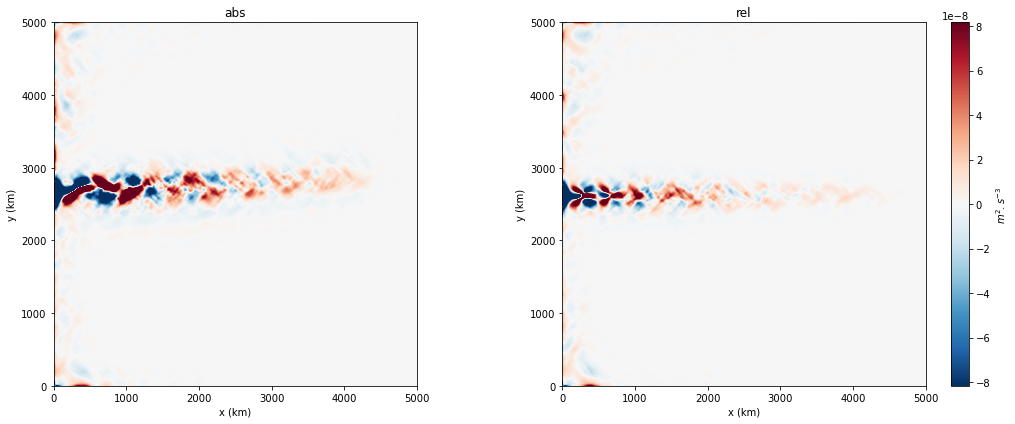

In [18]:
mke2epe_abs_i = integral_z(mke2epe_abs_me, dh, Delta, Ht)
mke2epe_rel_i = integral_z(mke2epe_rel_me, dh, Delta, Ht)

maxi = max(np.max(mke2epe_abs_i),np.abs(np.min(mke2epe_abs_i)))


fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,6),tight_layout=True)


col = ax1.imshow(mke2epe_abs_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/70, vmin = -maxi/70)
ax1.set_aspect('equal')
ax1.set_title('abs')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

#m = plt.cm.ScalarMappable(cmap='RdBu_r')
#m.set_array(mke2epe_abs_i)
#m.set_clim(-maxi/70, maxi/70)
#plt.colorbar(m, ax= ax1).set_label(r'$m^2.s^{-3}$')

col2 = ax2.imshow(mke2epe_rel_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/70, vmin = -maxi/70)
ax2.set_aspect('equal')
ax2.set_title('rel')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')

m2 = plt.cm.ScalarMappable(cmap='RdBu_r')
m2.set_array(mke2epe_rel_i)
m2.set_clim(-maxi/70, maxi/70)
plt.colorbar(m2, ax= ax2).set_label(r'$m^2.s^{-3}$')

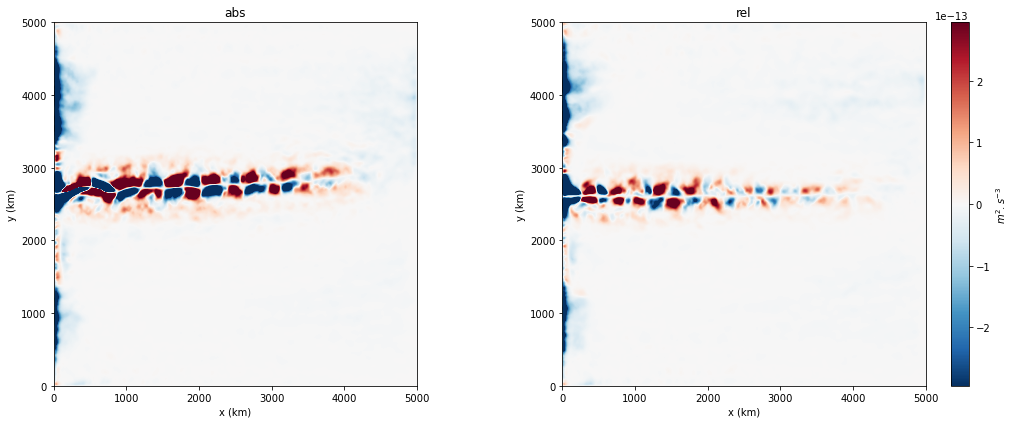

In [19]:
#mean PE to turbulent PE


mpe2epe_abs_i = -integral_z(mpe2epe_abs_me, dh, Delta, Ht)
mpe2epe_rel_i = -integral_z(mpe2epe_rel_me, dh, Delta, Ht)

maxi = max(np.max(mpe2epe_abs_i),np.abs(np.min(mpe2epe_abs_i)))


fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,6),tight_layout=True)


col = ax1.imshow(mpe2epe_abs_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/30, vmin = -maxi/30)
ax1.set_aspect('equal')
ax1.set_title('abs')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

#m = plt.cm.ScalarMappable(cmap='RdBu_r')
#m.set_array(mpe2epe_abs_i)
#m.set_clim(-maxi/30, maxi/30)
#plt.colorbar(m, ax= ax1).set_label(r'$m^2.s^{-3}$')

col2 = ax2.imshow(mpe2epe_rel_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/30, vmin = -maxi/30)
ax2.set_aspect('equal')
ax2.set_title('rel')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')

m2 = plt.cm.ScalarMappable(cmap='RdBu_r')
m2.set_array(mpe2epe_rel_i)
m2.set_clim(-maxi/30, maxi/30)
plt.colorbar(m2, ax= ax2).set_label(r'$m^2.s^{-3}$')

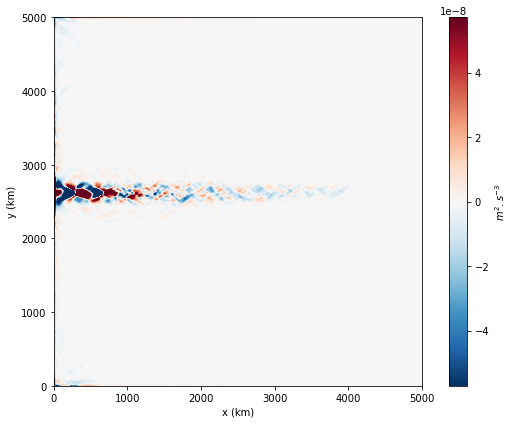

In [12]:
mke2epe_rel_i = integral_z(mke2epe_rel_me, dh, Delta, Ht)

fig, ax2 = plt.subplots(1, 1, figsize = (8,6),tight_layout=True)

col = ax2.imshow(mke2epe_rel_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/40, vmin = -maxi/40)
ax2.set_aspect('equal')
#ax2.set_title('rel')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(mke2epe_rel_i)
m.set_clim(-maxi/40, maxi/40)
plt.colorbar(m, ax= ax2).set_label(r'$m^2.s^{-3}$')

#savefig
#plt.savefig('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/figs_rel/mpe2eke.png')